## GAN to balance the training data-set
## This notebook is to apply WCGAN on Scania Dataset with PCA (PCs=11), with different Imbalance Ratio

**Yasmin Fathy <Fathy.Yasmin@gmail.com>**

**Latest Updates: 30/08/2020**

In [3]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', -1)

#Setup to show all results in jupiter not only the last one:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
from pprint import pprint

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## Evaluation

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, make_scorer,\
    recall_score, f1_score, precision_recall_curve, log_loss, cohen_kappa_score,roc_curve, auc
from tqdm import tqdm

In [5]:
RANDOM_STATE = 42

**APS Misclasification Cost Function**

In [6]:
def __perform_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        y_actual = list(y_actual)
        y_hat = list(y_hat)
        for i in range(len(y_hat)):
            if y_actual[i] == y_hat[i] == 1:
                TP += 1
            if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
                FP += 1
            if y_actual[i] == y_hat[i] == 0:
                TN += 1
            if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
                FN += 1

        return [TP, FP, TN, FN]

def custom_cost_fn_loss(y_actual, y_hat):
        [TP, FP, TN, FN] = __perform_measure(y_actual, y_hat)
        # print(len(list(y_actual)),
        #       len(list(y_hat)))
        # cm = confusion_matrix(list(y_actual), list(y_hat))
        # print(len(cm))
        # print(len(cm[0]))
        # print(cm)
        # FP = cm[0][1]
        # FN = cm[1][0]
        return (500 * FN) + (FP * 10)
    
APS_cost_fn = make_scorer(custom_cost_fn_loss, greater_is_better=False)

### ML Model Evalution

- **y** : original label in the testing-set
- **y_predict**: predicted label from the ML algorithm
- **y_predict_prob**: probability output of the algorithm about the minority class

**Plotting the precision, recall curve**

In [7]:
def plot_precession_recall_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='Precision Recall curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Precision Recall curve  '+ str(alg_name))
    plt.legend(loc="lower right")
    plt.show();

In [8]:
def plot_roc_auc_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

**Evaluating the results using a set of metrics**

In [9]:
def model_evaluaiton(y, y_predict, alg_name):        
            print(classification_report(y, list(y_predict)))
            cm = confusion_matrix(y, list(y_predict))
            print(cm)
            print("Accuracy:", accuracy_score(y, y_predict))
            print("roc_auc_score:", roc_auc_score(y, y_predict))
            print("precision_score:", precision_score(y, y_predict))
            print("recall_score:", recall_score(y, y_predict))
            print("f1_score:", f1_score(y, y_predict))
            FP = cm[0][1]
            FN = cm[1][0]
            print("CM: FP", FP)
            print("CM: FN", FN)
            print("APS Cost = ", (500 * FN) + (FP * 10))
            plot_precession_recall_curve(y, y_predict, alg_name)
            plot_roc_auc_curve(y, y_predict, alg_name)

**Finding the threshold that minimises the misclassification of the minority class i.e. class = 1 and apply the best threshold as post-processing steps**

In [10]:
def find_cut_off(y, y_predict_prob_maj):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict_prob_maj)
    min_cost = np.inf
    best_threshold = 0.5
    costs = []
    for threshold in tqdm(thresholds):
        #y_pred_threshold = np.where(scores > threshold, 0, 1)
        y_pred_threshold = y_predict_prob_maj > threshold
        tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
        cost = 10*fp + 500*fn
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    print("Best threshold: {:.4f}".format(best_threshold))
    print("Min cost: {:.2f}".format(min_cost))
    return best_threshold
    

---

## Read training and testing files

**Get the minority class samples**

In [11]:
def get_minority(df_train):
    return df_train[df_train['class'] == 1]

In [12]:
data_dir ="ScaniaDataset/dimReduction/"
df_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
df_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

data_dir ="ScaniaDataset/"
df_gan = pd.read_csv(data_dir+"WCGAN_Scania.csv")

df_orig_minority = get_minority(df_train)

# data_dir ="ScaniaDataset/imputation/"
# df_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
# df_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

In [13]:
df_train[10:12]

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
10,0.138328,-0.330887,-0.156912,-0.012809,0.061510,-0.037770,-0.046260,0.00685,-0.024045,0.021380,-0.005061,0
11,0.023933,-0.149777,-0.167296,-0.038588,0.058541,-0.037378,0.065629,0.02009,0.042327,-0.035638,0.003502,0


In [14]:
df_train["class"].value_counts()

df_test["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

In [15]:
df_train.head()
df_test.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,-0.357653,0.149168,0.785559,0.107379,-0.068720,-0.028512,0.128307,0.002902,-0.073669,0.079233,-0.019663,0
1,-0.009868,0.178451,-0.153641,-0.106095,0.115751,0.677376,0.038713,0.021226,0.052543,-0.016909,-0.012898,0
2,0.036263,-0.202770,-0.164386,-0.072079,0.131766,-0.043973,-0.051563,-0.000143,0.000497,-0.034116,-0.000904,0
3,0.207965,-0.419020,-0.145090,-0.048601,-0.000098,-0.007554,-0.008067,0.004260,0.006622,0.011792,-0.001259,0
4,-0.111736,0.259781,-0.174570,-0.061653,-0.000418,-0.020208,0.079826,-0.010607,0.004089,-0.047178,-0.014056,0


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,0.161155,-0.296518,-0.147703,-0.064035,-0.017811,-0.017302,0.001606,0.008635,0.022569,0.004805,-0.000669,0
1,0.197147,-0.390714,-0.145632,-0.052749,-0.003007,-0.008112,-0.006774,0.005026,0.008747,0.010879,-0.000986,0
2,-0.271152,0.611412,-0.183003,-0.143001,-0.002290,-0.010953,0.107131,-0.045472,0.038387,-0.092350,0.044199,0
3,-0.134755,0.120177,-0.180050,-0.094396,0.112898,-0.045628,0.058169,0.005929,0.011544,-0.038997,-0.004686,0
4,0.171726,-0.324381,-0.146679,-0.064361,-0.004982,-0.002021,-0.007429,0.004521,0.007393,0.011175,-0.000230,0


----

### Use data generated by GAN to preserve different ratio between the majoirty and minority classes

In [16]:
from collections import Counter
from numpy import log
from imblearn.over_sampling import SMOTE 

Using TensorFlow backend.


**Using the Shannon entropy as a measure of balance**
- Where IR tends to be:
    - 0 when the data is highly imbalanced and 
    - 1 when the data is balanced.

- Inspired from: 
https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance


In [17]:
def imbalance_ratio(seq):
    n = len(seq)
    classes = [(label,float(count)) for 
               label,count in Counter(seq).items()]
    #print(classes)
    k = len(classes)
    #print(k)
    #calculate shannon entropy
    H = -sum([ (count/n) * log((count/n)) 
              for label,count in classes]) 
    #print(H)
    # get imbalance ratio
    IR = H/log(k)
    print("Non-normliased = ", str(H))
    print("IR = ", str(IR))
    return IR # near 0: high imbalance, near 1: high balance

**Check if we have the same value report for Normalised Shannon Entropy that is calculated in paper "A methodology..." isn't normalised**
- It turns out the shannon value in their paper isn't normalised, check the example on the original data
- Original data has the following counts for each class
[(0, 59000.0), (1, 1000.0)]

In [18]:
log((1/60)) 

-4.0943445622221

In [19]:
#[(0, 59000.0), (1, 1000.0)]
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))/log(2)

0.08476607571480994

0.1222915970693747

**Measure IR for the original data**

In [20]:
imbalance_ratio(df_train["class"])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747


0.1222915970693747

**To reproduce Case II Experiements:**
- sampling_strategy = 2/59 => IR = 0.2
- sampling_strategy = 5/59 => IR = 0.4
- sampling_strategy = 9/59, 10/59, 11/59 => IR = 0.6
- sampling_strategy = 18/59 => IR = 0.8
- sampling_strategy = 59/59 => IR = 1.0

**define a dataframe for each case**

- IR =  0.1222915970693747 (original case we already have its results)

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 2000 (3.278688524590164%)
After OverSampling, counts of label '0': 59000 (96.72131147540983%)



- IR =  0.20818094555717104

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 5000 (7.8125%)
After OverSampling, counts of label '0': 59000 (92.1875%)


- IR =  0.3955378064564774


Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 10000 (14.492753623188406%)
After OverSampling, counts of label '0': 59000 (85.5072463768116%)




- IR =  0.596999516760455

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 18000 (23.376623376623375%)
After OverSampling, counts of label '0': 59000 (76.62337662337663%)



- IR =  0.7845191388986642


Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 59000 (50.0%)
After OverSampling, counts of label '0': 59000 (50.0%)
IR =  1.0

In [21]:
#sample_strategies = [2, 5, 10, 18, 59]

In [22]:
x=imbalance_ratio(df_train['class'])

print("".join(["="]*20))
## create df for IR = 0.2
df_train_2 = pd.concat([df_train, df_gan[:1000]])
x=imbalance_ratio(df_train_2['class'])
c_0 = len(df_train_2[df_train_2["class"]==0])
c_1 = len(df_train_2[df_train_2["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_2))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_2))* 100))

print("".join(["="]*20))

## create df for IR = 0.4
df_train_5 = pd.concat([df_train, df_gan[1000:5000]])
x=imbalance_ratio(df_train_5['class'])
c_0 = len(df_train_5[df_train_5["class"]==0])
c_1 = len(df_train_5[df_train_5["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_5))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_5))* 100))
print("".join(["="]*20))

## create df for IR = 0.6
df_train_10 = pd.concat([df_train, df_gan[5000:14000]])
x=imbalance_ratio(df_train_10['class'])
c_0 = len(df_train_10[df_train_10["class"]==0])
c_1 = len(df_train_10[df_train_10["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_10))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_10))* 100))
print("".join(["="]*20))

# ## create df for IR = 0.8
# df_train_18 = pd.concat([df_train, df_gan[14000:31000]])
# x=imbalance_ratio(df_train_18['class'])
# c_0 = len(df_train_18[df_train_18["class"]==0])
# c_1 = len(df_train_18[df_train_18["class"]==1])
# print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_18))* 100))
# print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_18))* 100))
# print("".join(["="]*20))

# ## create df for IR = 1.0
# df_train_59 = pd.concat([df_train, df_gan])
# x=imbalance_ratio(df_train_59['class'])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747
Non-normliased =  0.14430003545925657
IR =  0.20818094555717104
After OverSampling, counts of label '0': 59000 (96.72131147540983%)
After OverSampling, counts of label '1': 2000 (3.278688524590164%)

Non-normliased =  0.27416591535017265
IR =  0.3955378064564774
After OverSampling, counts of label '0': 59000 (92.1875%)
After OverSampling, counts of label '1': 5000 (7.8125%)

Non-normliased =  0.41380853183815924
IR =  0.596999516760455
After OverSampling, counts of label '0': 59000 (85.5072463768116%)
After OverSampling, counts of label '1': 10000 (14.492753623188406%)



## Get difference between generated and original
**Note: SMOTE concatenates the newly generated samples to the end of the original input data and returns that as the output**
- ref: https://datascience.stackexchange.com/questions/12768/location-of-the-resampled-data-from-smote

In [23]:
# df_minroty: is the data samples of the minority class in the original data
# df_generated: is all data samples including synthetic generated minority class and original data samples

from scipy import stats
def get_ks_test(df_minroty, df_generated, return_generated_df = False):
    # get the generated samples from smote by getting the difference between original dataset in "df_train" and sampled dataset "df_generated"
    # (which contains/combines original and generated data)
    minority_generated = df_generated[~df_generated.apply(tuple,1).isin(df_train.apply(tuple,1))]
    no_cols = len(df_minroty.columns)-1
    for idx in range(0, no_cols):
        print(stats.ks_2samp(df_minroty.iloc[:,idx], 
                       minority_generated.iloc[:, idx]))
    if return_generated_df:
        return minority_generated
    

In [24]:
# minority_generated = df_train_5[~df_train_5.apply(tuple,1).isin(df_train.apply(tuple,1))]
# minority_generated = minority_generated.drop(['class'], axis=1)
# # minority_generated

# minority_original = df_minority.drop(['class'], axis=1)
# # minority_original

# minority_original.corrwith(minority_generated, axis=0)

In [25]:
# from scipy.stats import pearsonr
# corr, _ = pearsonr(minority_original, minority_generated)
# corr
# p = minority_generated.to_numpy()
# q = minority_original.to_numpy()

# BC=np.sum(np.sqrt(p*q))
# BC

In [26]:
get_ks_test(df_orig_minority, df_train_2)

Ks_2sampResult(statistic=0.844, pvalue=0.0)
Ks_2sampResult(statistic=0.647, pvalue=1.445156540140849e-197)
Ks_2sampResult(statistic=0.93, pvalue=0.0)
Ks_2sampResult(statistic=0.872, pvalue=0.0)
Ks_2sampResult(statistic=0.49, pvalue=2.8333430413611358e-109)
Ks_2sampResult(statistic=0.395, pvalue=4.9525690933187676e-70)
Ks_2sampResult(statistic=0.471, pvalue=1.2279568309794965e-100)
Ks_2sampResult(statistic=0.419, pvalue=4.9383656742309225e-79)
Ks_2sampResult(statistic=0.439, pvalue=5.368503601575849e-87)
Ks_2sampResult(statistic=0.433, pvalue=1.4578519998015312e-84)
Ks_2sampResult(statistic=0.388, pvalue=1.614348883239596e-67)


In [27]:
get_ks_test(df_orig_minority, df_train_5)

Ks_2sampResult(statistic=0.84275, pvalue=0.0)
Ks_2sampResult(statistic=0.6475, pvalue=9.374510290586206e-292)
Ks_2sampResult(statistic=0.9335, pvalue=0.0)
Ks_2sampResult(statistic=0.865, pvalue=0.0)
Ks_2sampResult(statistic=0.48625, pvalue=1.0147095679360037e-164)
Ks_2sampResult(statistic=0.394, pvalue=2.7040136977852724e-108)
Ks_2sampResult(statistic=0.46025, pvalue=1.2776926712226806e-147)
Ks_2sampResult(statistic=0.4215, pvalue=7.057555265212734e-124)
Ks_2sampResult(statistic=0.4355, pvalue=3.2478052345649814e-132)
Ks_2sampResult(statistic=0.448, pvalue=6.880285854671844e-140)
Ks_2sampResult(statistic=0.38975, pvalue=5.579320740715114e-106)


In [28]:
get_ks_test(df_orig_minority, df_train_10)

Ks_2sampResult(statistic=0.8451111111111111, pvalue=0.0)
Ks_2sampResult(statistic=0.6464444444444445, pvalue=0.0)
Ks_2sampResult(statistic=0.932, pvalue=0.0)
Ks_2sampResult(statistic=0.866, pvalue=0.0)
Ks_2sampResult(statistic=0.486, pvalue=4.565780090073535e-185)
Ks_2sampResult(statistic=0.3948888888888889, pvalue=2.513072991270185e-122)
Ks_2sampResult(statistic=0.46, pvalue=7.708106887726307e-166)
Ks_2sampResult(statistic=0.4192222222222222, pvalue=8.20547098303867e-138)
Ks_2sampResult(statistic=0.43544444444444447, pvalue=1.1905142874884938e-148)
Ks_2sampResult(statistic=0.44155555555555553, pvalue=7.693000220147728e-153)
Ks_2sampResult(statistic=0.3837777777777778, pvalue=1.4575311132111094e-115)


In [29]:
# get_ks_test(df_orig_minority, df_train_18)

In [30]:
# get_ks_test(df_orig_minority, df_train_59)

In [31]:
# df_2_generated = df_train_2[~df_train_2.apply(tuple,1).isin(df_train.apply(tuple,1))]
# len(df_2_generated)

**Prepare test dataset**

In [32]:
y_test = df_test['class']
X_test = df_test.drop(['class'], axis=1)

In [33]:
len(X_test)

16000

----

## ML Predictive models on the data with augmentation minotity samples generated from GAN
**LR, RF, XGBoost are trained and tested for each case mentioned above**

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [35]:
#scoring_fn = "f1_weighted"
scoring_fn = APS_cost_fn

**Prepare training dataset**

In [36]:
def get_train_data(df_t):
    y_train = df_t['class']
    X_train = df_t.drop(['class'], axis=1)
    return X_train, y_train
    

**Make prediction of best model given X_test**

In [37]:
def model_prediction(best_model, X_test):
    print("Best estimator: ", best_model.best_estimator_)
    # X = X.values.reshape(-1, 1)
    model_prediction = best_model.predict(X_test)
    model_prob_prediction = best_model.predict_proba(X_test) 
    return model_prediction, model_prob_prediction

### Logistic Regression: 

In [38]:
# y_train = df_train['class']
# X_train = df_train.drop(['class'], axis=1)

In [39]:
def lr_model(X_train, y_train):
    LR_hyperparameters = dict(C=[0.01, 1, 10, 100],
                             max_iter=[6000])  # hyperparameter options

    # # Best options obtained from running the params mentioned above
#     LR_hyperparameters = dict(C=[1], max_iter=[6000])  # hyperparameter options
    LR_clf = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
                               param_grid=LR_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

    LR_best_model = LR_clf.fit(X_train, y_train)
    return LR_best_model

### df_train_2 (i.e. IR = 0.2)

In [40]:
X_train_2, y_train_2 = get_train_data(df_train_2)
LR_best_model_2 = lr_model(X_train_2, y_train_2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.6s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.98      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14486  1139]
 [    9   366]]
Accuracy: 0.92825
roc_auc_score: 0.951552
precision_score: 0.2431893687707641
recall_score: 0.976
f1_score: 0.3893617021276596
CM: FP 1139
CM: FN 9
APS Cost =  15890


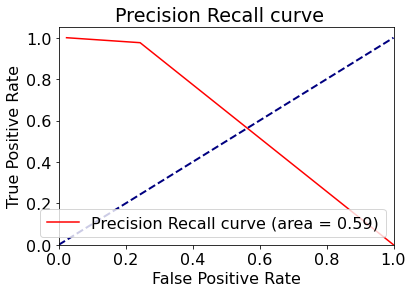

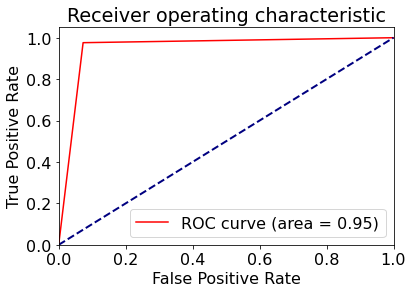

In [41]:
LR_model_pred_test_2, LR_model_prob_pred_test_2 = model_prediction(LR_best_model_2, X_test)
model_evaluaiton(y_test, LR_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     59000
         1.0       0.26      0.77      0.39      2000

    accuracy                           0.92     61000
   macro avg       0.63      0.85      0.67     61000
weighted avg       0.97      0.92      0.94     61000

[[54598  4402]
 [  453  1547]]
Accuracy: 0.9204098360655738
roc_auc_score: 0.8494449152542373
precision_score: 0.26004370482434025
recall_score: 0.7735
f1_score: 0.3892313498553278
CM: FP 4402
CM: FN 453
APS Cost =  270520


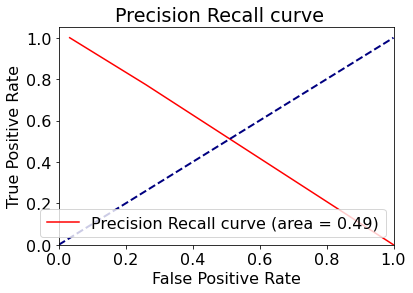

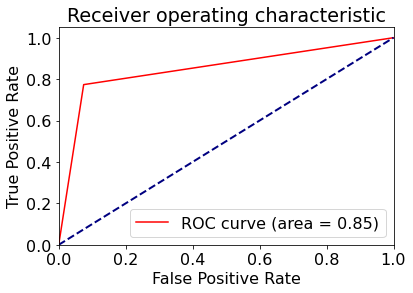

In [42]:
LR_model_pred_train_2, LR_model_prob_pred_train_2 = model_prediction(LR_best_model_2, X_train_2)
model_evaluaiton(y_train_2, LR_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [43]:
LR_best_th_2 = find_cut_off(y_test, LR_model_prob_pred_test_2[:,1])

100%|██████████| 12745/12745 [19:07<00:00, 11.11it/s]

Best threshold: 0.6148
Min cost: 15470.00


In [44]:
LR_best_th_2

0.614753477025771

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.97      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.95      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14728   897]
 [   13   362]]
Accuracy: 0.943125
roc_auc_score: 0.9539626666666667
precision_score: 0.2875297855440826
recall_score: 0.9653333333333334
f1_score: 0.44308445532435736
CM: FP 897
CM: FN 13
APS Cost =  15470


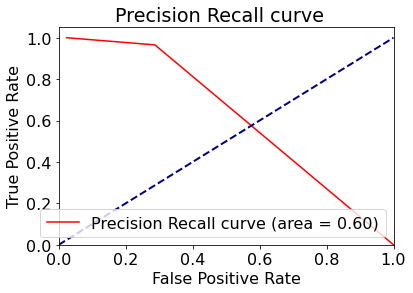

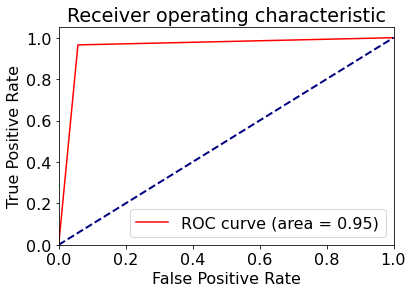

In [45]:
LR_predict_test_th_2 = LR_model_prob_pred_test_2[:,1] > LR_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [46]:
(1.0-LR_best_th_2)
lr_th_2 = round((1.0-LR_best_th_2),3)
lr_th_2

0.385246522974229

0.385

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.97      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.95      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14728   897]
 [   13   362]]
Accuracy: 0.943125
roc_auc_score: 0.9539626666666667
precision_score: 0.2875297855440826
recall_score: 0.9653333333333334
f1_score: 0.44308445532435736
CM: FP 897
CM: FN 13
APS Cost =  15470


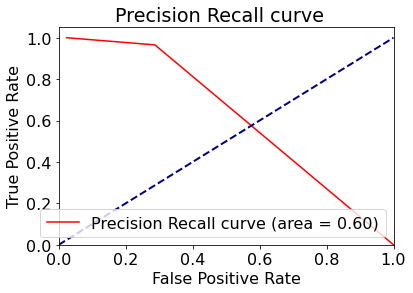

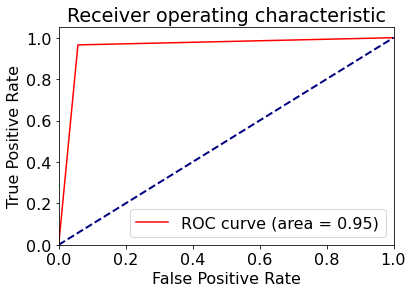

In [47]:
y_2 = LR_model_prob_pred_test_2[:,0] < lr_th_2
model_evaluaiton(y_test, y_2, "")

----

### Logistic Regression : df_train_5 (i.e. IR = 0.4)

In [48]:
X_train_5, y_train_5 = get_train_data(df_train_5)
LR_best_model_5 = lr_model(X_train_5, y_train_5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.3s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     15625
           1       0.20      0.98      0.33       375

    accuracy                           0.91     16000
   macro avg       0.60      0.94      0.64     16000
weighted avg       0.98      0.91      0.94     16000

[[14138  1487]
 [    6   369]]
Accuracy: 0.9066875
roc_auc_score: 0.944416
precision_score: 0.19881465517241378
recall_score: 0.984
f1_score: 0.3307933662034962
CM: FP 1487
CM: FN 6
APS Cost =  17870


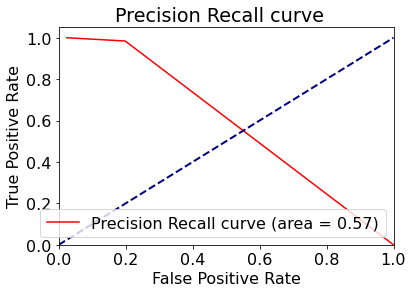

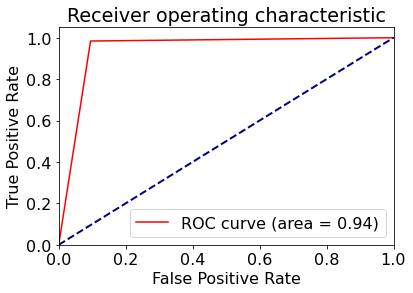

In [49]:
LR_model_pred_test_5, LR_model_prob_pred_test_5 = model_prediction(LR_best_model_5, X_test)
model_evaluaiton(y_test, LR_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     59000
         1.0       0.41      0.80      0.54      5000

    accuracy                           0.89     64000
   macro avg       0.69      0.85      0.74     64000
weighted avg       0.94      0.89      0.91     64000

[[53182  5818]
 [ 1003  3997]]
Accuracy: 0.893421875
roc_auc_score: 0.8503949152542372
precision_score: 0.4072338257768721
recall_score: 0.7994
f1_score: 0.5395882551468106
CM: FP 5818
CM: FN 1003
APS Cost =  559680


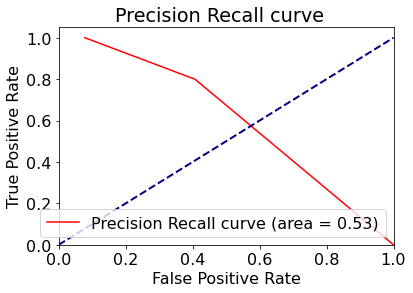

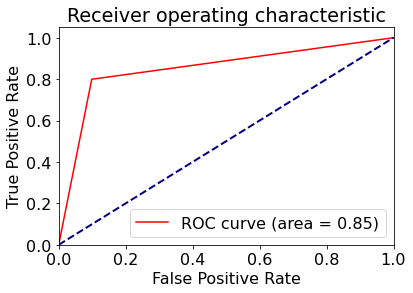

In [50]:
LR_model_pred_train_5, LR_model_prob_pred_train_5 = model_prediction(LR_best_model_5, X_train_5)
model_evaluaiton(y_train_5, LR_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [51]:
LR_best_th_5 = find_cut_off(y_test, LR_model_prob_pred_test_5[:,1])

100%|██████████| 13477/13477 [18:19<00:00, 12.25it/s] 

Best threshold: 0.5817
Min cost: 16400.00


In [52]:
LR_best_th_5

0.5816720353147594

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14485  1140]
 [   10   365]]
Accuracy: 0.928125
roc_auc_score: 0.9501866666666666
precision_score: 0.2425249169435216
recall_score: 0.9733333333333334
f1_score: 0.38829787234042556
CM: FP 1140
CM: FN 10
APS Cost =  16400


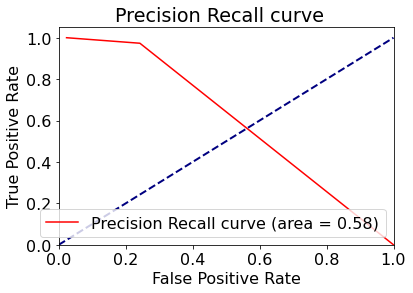

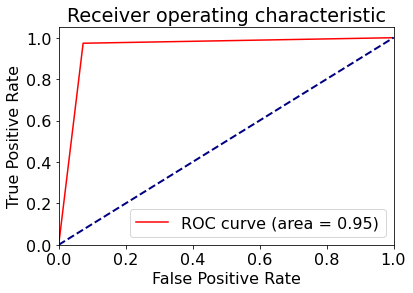

In [53]:
LR_predict_test_th_5 = LR_model_prob_pred_test_5[:,1] > LR_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [54]:
(1.0-LR_best_th_5)
lr_th_5 = round((1.0-LR_best_th_5),3)
lr_th_5

0.4183279646852406

0.418

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14485  1140]
 [   10   365]]
Accuracy: 0.928125
roc_auc_score: 0.9501866666666666
precision_score: 0.2425249169435216
recall_score: 0.9733333333333334
f1_score: 0.38829787234042556
CM: FP 1140
CM: FN 10
APS Cost =  16400


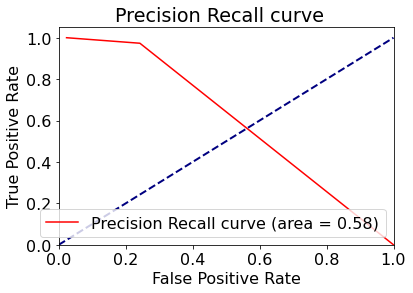

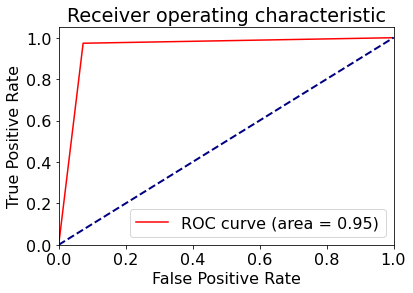

In [55]:
y_5 = LR_model_prob_pred_test_5[:,0] < lr_th_5
model_evaluaiton(y_test, y_5, "")

-----

### Logistic Regression : df_train_10 (i.e. IR = 0.6)

In [56]:
X_train_10, y_train_10 = get_train_data(df_train_10)
LR_best_model_10 = lr_model(X_train_10, y_train_10)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    4.0s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.8s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     15625
           1       0.19      0.98      0.32       375

    accuracy                           0.90     16000
   macro avg       0.59      0.94      0.63     16000
weighted avg       0.98      0.90      0.93     16000

[[14045  1580]
 [    6   369]]
Accuracy: 0.900875
roc_auc_score: 0.9414399999999999
precision_score: 0.1893278604412519
recall_score: 0.984
f1_score: 0.31755593803786575
CM: FP 1580
CM: FN 6
APS Cost =  18800


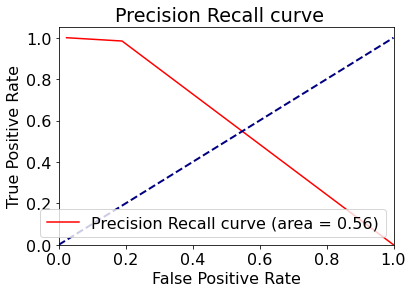

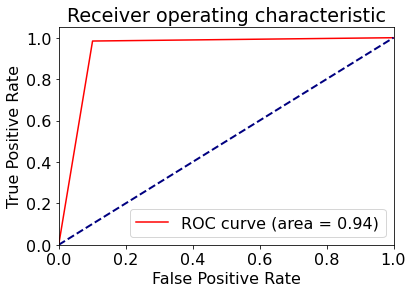

In [57]:
LR_model_pred_test_10, LR_model_prob_pred_test_10 = model_prediction(LR_best_model_10, X_test)
model_evaluaiton(y_test, LR_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93     59000
         1.0       0.57      0.82      0.67     10000

    accuracy                           0.88     69000
   macro avg       0.77      0.86      0.80     69000
weighted avg       0.91      0.88      0.89     69000

[[52793  6207]
 [ 1842  8158]]
Accuracy: 0.8833478260869565
roc_auc_score: 0.8552983050847457
precision_score: 0.567908109989558
recall_score: 0.8158
f1_score: 0.669649086804843
CM: FP 6207
CM: FN 1842
APS Cost =  983070


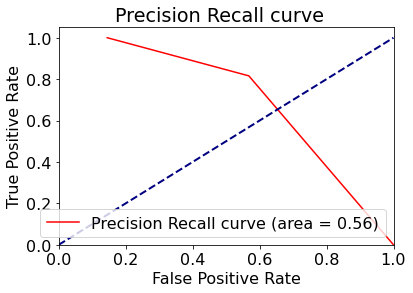

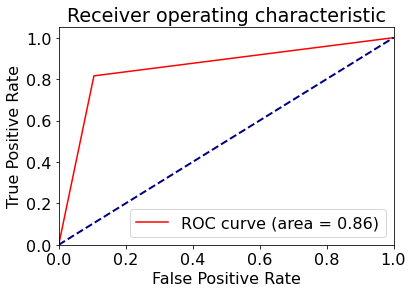

In [58]:
LR_model_pred_train_10, LR_model_prob_pred_train_10 = model_prediction(LR_best_model_10, X_train_10)
model_evaluaiton(y_train_10, LR_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [59]:
LR_best_th_10 = find_cut_off(y_test, LR_model_prob_pred_test_10[:,1])

100%|██████████| 13481/13481 [22:20<00:00, 10.06it/s] 

Best threshold: 0.7206
Min cost: 17100.00


In [60]:
LR_best_th_10

0.7205780336684381

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.96      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.95      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14715   910]
 [   16   359]]
Accuracy: 0.942125
roc_auc_score: 0.9495466666666666
precision_score: 0.28289992119779356
recall_score: 0.9573333333333334
f1_score: 0.43673965936739656
CM: FP 910
CM: FN 16
APS Cost =  17100


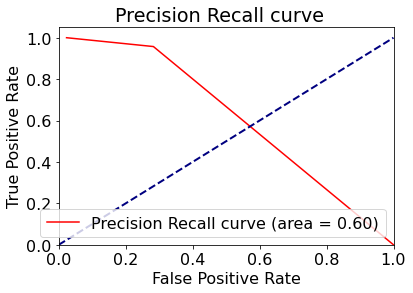

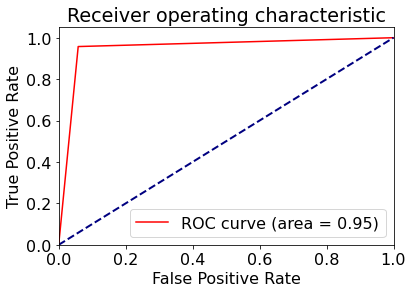

In [61]:
LR_predict_test_th_10 = LR_model_prob_pred_test_10[:,1] > LR_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [62]:
(1.0-LR_best_th_10)
lr_th_3 = round((1.0-LR_best_th_10),3)
lr_th_3

0.2794219663315619

0.279

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.96      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.95      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14715   910]
 [   16   359]]
Accuracy: 0.942125
roc_auc_score: 0.9495466666666666
precision_score: 0.28289992119779356
recall_score: 0.9573333333333334
f1_score: 0.43673965936739656
CM: FP 910
CM: FN 16
APS Cost =  17100


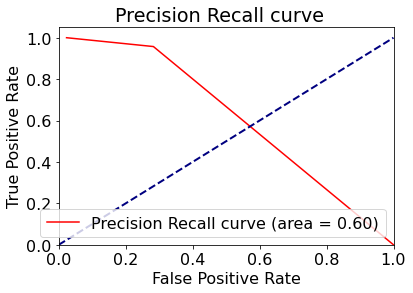

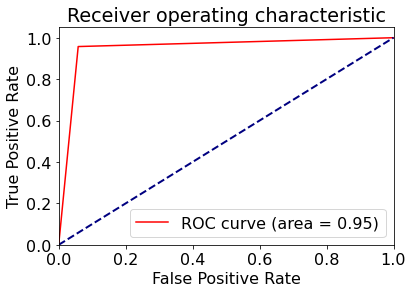

In [63]:
y_10 = LR_model_prob_pred_test_10[:,0] < lr_th_3
model_evaluaiton(y_test, y_10, "")

----

### Random Forest

In [64]:
def RF_model(X_train, y_train):
    RF_hyperparameters = {
                'n_estimators': [50, 100, 250],
               #  'max_features': ['auto', 'sqrt', 'log2'],
                # 'max_depth': [5, 6, 8, None],
                'max_depth': [5, 6, 8],
                'criterion': ['gini', 'entropy']}

    ## Best Params based on running the previous range of hyperparameter
#     RF_hyperparameters = {
#                           'n_estimators': [250],
#                            'max_depth': [5],
#                           'criterion': ['entropy']}
    RF_clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state= RANDOM_STATE),
                                   param_grid=RF_hyperparameters, cv=5,
                                   verbose=2, scoring=scoring_fn, n_jobs=-1)

    RF_best_model = RF_clf.fit(X_train, y_train)
    return RF_best_model

### df_train_2 (i.e. IR = 0.2)

In [65]:
X_train_2, y_train_2 = get_train_data(df_train_2)
RF_best_model_2 = RF_model(X_train_2, y_train_2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.5min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.97      0.43       375

    accuracy                           0.94     16000
   macro avg       0.64      0.95      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14656   969]
 [   12   363]]
Accuracy: 0.9386875
roc_auc_score: 0.952992
precision_score: 0.272522522522522

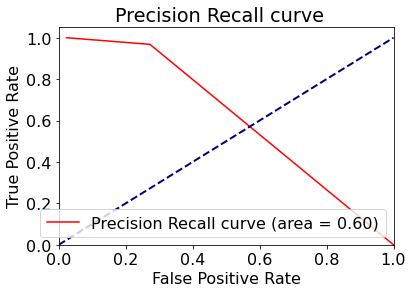

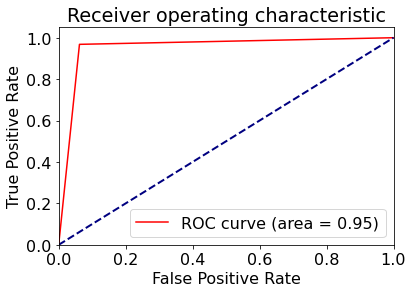

In [66]:
RF_model_pred_test_2, RF_model_prob_pred_test_2 = model_prediction(RF_best_model_2, X_test)
model_evaluaiton(y_test, RF_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     59000
         1.0       0.34      0.98      0.51      2000

    accuracy                           0.94     61000
   macro avg       0.67      0.96      0.74     61000
weighted avg       0.98      0.94      0.95     61000

[[55214  3786]
 [   44  1956]]
Accuracy: 0.9372131147540984
roc_auc_score: 0.9569152542372882
precision_score

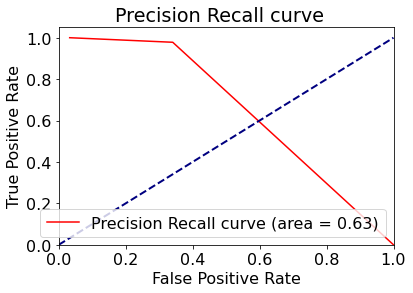

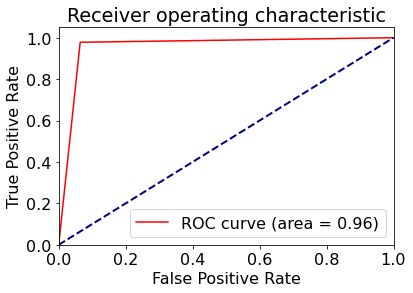

In [67]:
RF_model_pred_train_2, RF_model_prob_pred_train_2 = model_prediction(RF_best_model_2, X_train_2)
model_evaluaiton(y_train_2, RF_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [68]:
RF_best_th_2 = find_cut_off(y_test, RF_model_prob_pred_test_2[:,1])

100%|██████████| 6745/6745 [12:59<00:00,  8.65it/s]

Best threshold: 0.4708
Min cost: 14340.00


In [69]:
RF_best_th_2

0.47081910421793777

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.98      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14591  1034]
 [    8   367]]
Accuracy: 0.934875
roc_auc_score: 0.9562453333333334
precision_score: 0.26195574589578874
recall_score: 0.9786666666666667
f1_score: 0.41328828828828834
CM: FP 1034
CM: FN 8
APS Cost =  14340


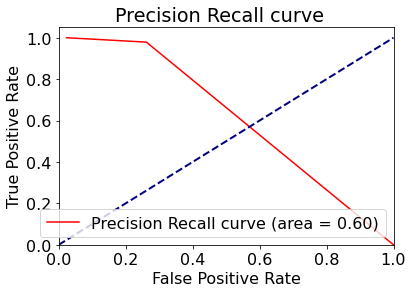

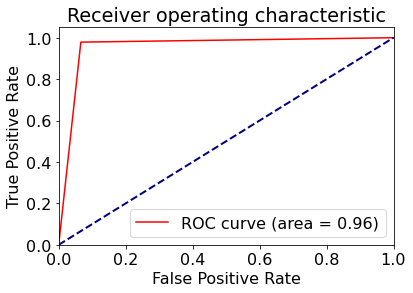

In [70]:
RF_predict_test_th_2 = RF_model_prob_pred_test_2[:,1] > RF_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [71]:
(1.0-RF_best_th_2)
rf_th_2 = round((1.0-RF_best_th_2),3)
rf_th_2

0.5291808957820623

0.529

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.98      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14591  1034]
 [    8   367]]
Accuracy: 0.934875
roc_auc_score: 0.9562453333333334
precision_score: 0.26195574589578874
recall_score: 0.9786666666666667
f1_score: 0.41328828828828834
CM: FP 1034
CM: FN 8
APS Cost =  14340


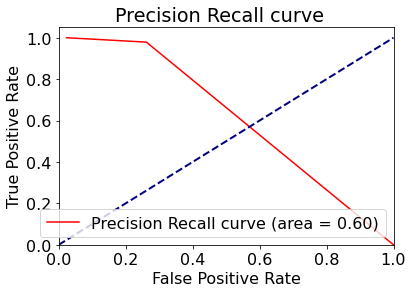

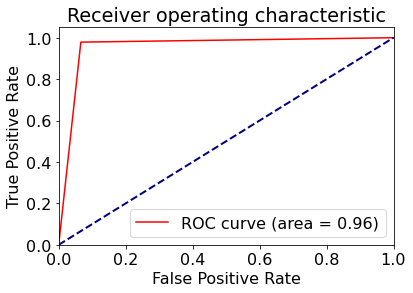

In [72]:
y_2 = RF_model_prob_pred_test_2[:,0] < rf_th_2
model_evaluaiton(y_test, y_2, "")

------

### df_train_5 (i.e. IR = 0.4)

In [73]:
X_train_5, y_train_5 = get_train_data(df_train_5)
RF_best_model_5 = RF_model(X_train_5, y_train_5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.8min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.43      0.89      0.58       375

    accuracy                           0.97     16000
   macro avg       0.71      0.93      0.78     16000
weighted avg       0.98      0.97      0.98     16000

[[15189   436]
 [   43   332]]
Accuracy: 0.9700625
roc_auc_score: 0.9287146666666667
precision_score: 0.4

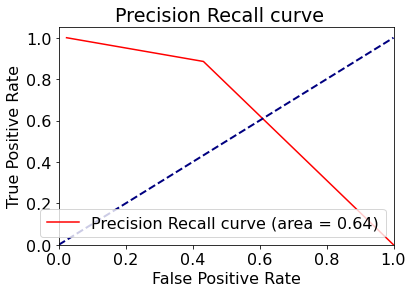

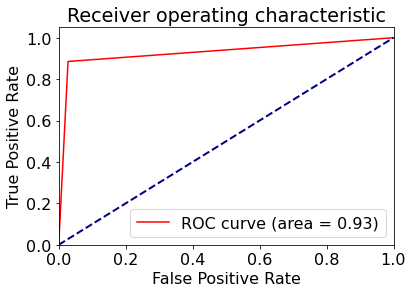

In [74]:
RF_model_pred_test_5, RF_model_prob_pred_test_5 = model_prediction(RF_best_model_5, X_test)
model_evaluaiton(y_test, RF_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     59000
         1.0       0.75      0.99      0.85      5000

    accuracy                           0.97     64000
   macro avg       0.87      0.98      0.92     64000
weighted avg       0.98      0.97      0.97     64000

[[57322  1678]
 [   70  4930]]
Accuracy: 0.9726875
roc_auc_score: 0.9787796610169491
precision_score: 0.7

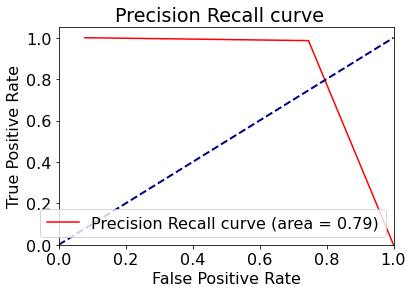

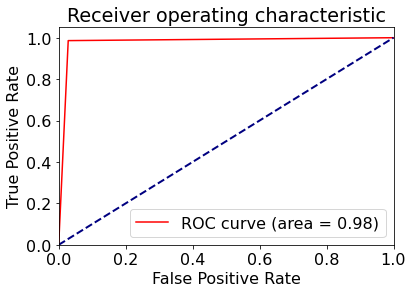

In [75]:
RF_model_pred_train_5, RF_model_prob_pred_train_5 = model_prediction(RF_best_model_5, X_train_5)
model_evaluaiton(y_train_5, RF_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [76]:
RF_best_th_5 = find_cut_off(y_test, RF_model_prob_pred_test_5[:,1])

100%|██████████| 9018/9018 [12:18<00:00, 12.22it/s]

Best threshold: 0.1761
Min cost: 12810.00


In [77]:
RF_best_th_5

0.17608281710601958

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14694   931]
 [    7   368]]
Accuracy: 0.941375
roc_auc_score: 0.9608746666666667
precision_score: 0.28329484218629714
recall_score: 0.9813333333333333
f1_score: 0.43966547192353633
CM: FP 931
CM: FN 7
APS Cost =  12810


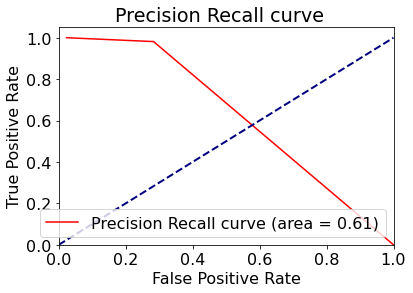

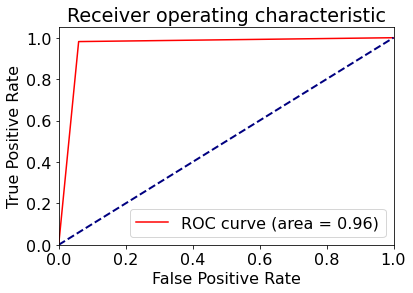

In [78]:
RF_predict_test_th_5 = RF_model_prob_pred_test_5[:,1] > RF_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [79]:
(1.0-RF_best_th_5)
rf_th_5 = round((1.0-RF_best_th_5),3)
rf_th_5

0.8239171828939804

0.824

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14693   932]
 [    7   368]]
Accuracy: 0.9413125
roc_auc_score: 0.9608426666666665
precision_score: 0.28307692307692306
recall_score: 0.9813333333333333
f1_score: 0.4394029850746269
CM: FP 932
CM: FN 7
APS Cost =  12820


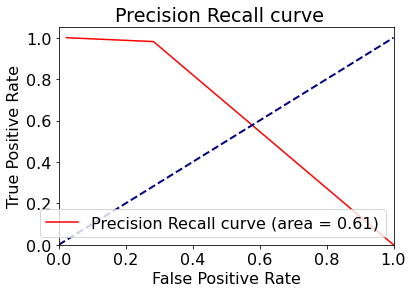

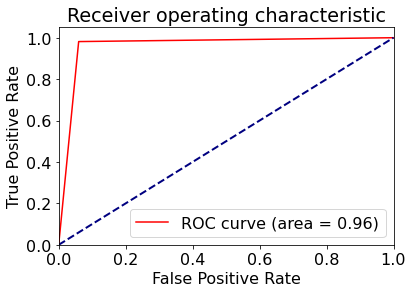

In [80]:
y_5 = RF_model_prob_pred_test_5[:,0] < rf_th_5
model_evaluaiton(y_test, y_5, "")

-----

### df_train_10 (i.e. IR = 0.6)

In [81]:
X_train_10, y_train_10 = get_train_data(df_train_10)
RF_best_model_10 = RF_model(X_train_10, y_train_10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.2min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     15625
           1       0.44      0.83      0.58       375

    accuracy                           0.97     16000
   macro avg       0.72      0.90      0.78     16000
weighted avg       0.98      0.97      0.98     16000

[[15227   398]
 [   62   313]]
Accuracy: 0.97125
roc_auc_score: 0.9045973333333333
precision_score: 0.440

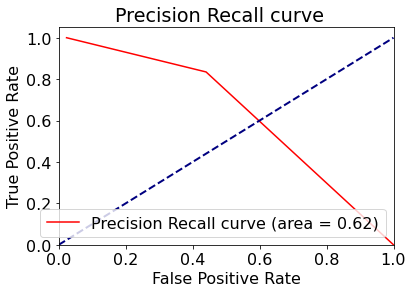

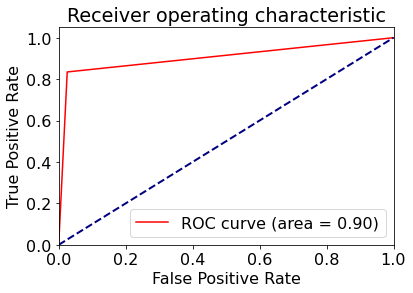

In [82]:
RF_model_pred_test_10, RF_model_prob_pred_test_10 = model_prediction(RF_best_model_10, X_test)
model_evaluaiton(y_test, RF_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     59000
         1.0       0.86      0.98      0.92     10000

    accuracy                           0.98     69000
   macro avg       0.93      0.98      0.95     69000
weighted avg       0.98      0.98      0.98     69000

[[57429  1571]
 [  151  9849]]
Accuracy: 0.9750434782608696
roc_auc_score: 0.9791364406779662
precision_s

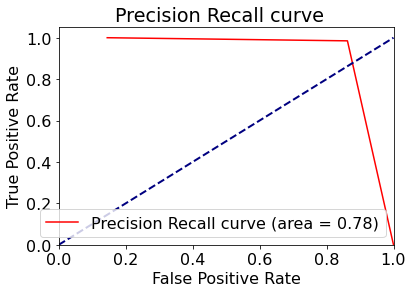

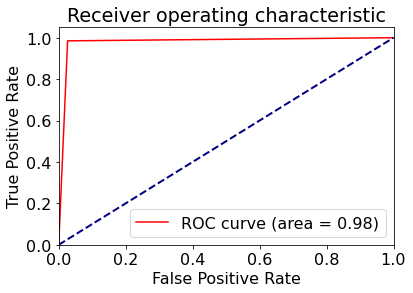

In [83]:
RF_model_pred_train_10, RF_model_prob_pred_train_10 = model_prediction(RF_best_model_10, X_train_10)
model_evaluaiton(y_train_10, RF_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [84]:
RF_best_th_10 = find_cut_off(y_test, RF_model_prob_pred_test_10[:,1])

100%|██████████| 10390/10390 [11:00<00:00, 15.73it/s]

Best threshold: 0.1672
Min cost: 14900.00


In [85]:
RF_best_th_10

0.1672029281722567

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.98      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14535  1090]
 [    8   367]]
Accuracy: 0.931375
roc_auc_score: 0.9544533333333334
precision_score: 0.25188743994509266
recall_score: 0.9786666666666667
f1_score: 0.40065502183406115
CM: FP 1090
CM: FN 8
APS Cost =  14900


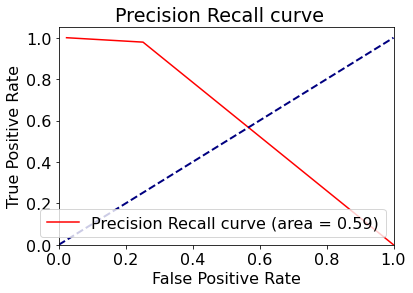

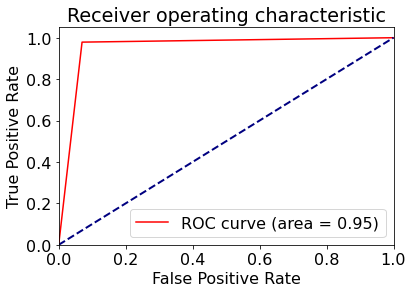

In [86]:
RF_predict_test_th_10 = RF_model_prob_pred_test_10[:,1] > RF_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [87]:
(1.0-RF_best_th_10)
rf_th_10 = round((1.0-RF_best_th_10),3)
rf_th_10

0.8327970718277433

0.833

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.98      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14533  1092]
 [    8   367]]
Accuracy: 0.93125
roc_auc_score: 0.9543893333333334
precision_score: 0.25154215215901304
recall_score: 0.9786666666666667
f1_score: 0.40021810250817885
CM: FP 1092
CM: FN 8
APS Cost =  14920


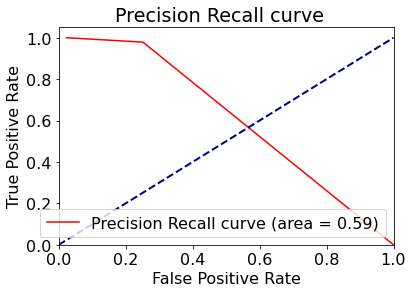

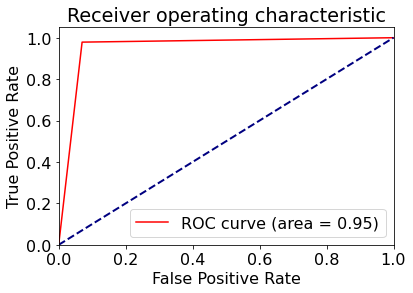

In [88]:
y_10 = RF_model_prob_pred_test_10[:,0] < rf_th_10
model_evaluaiton(y_test, y_10, "")

---

----

## XGBoost

In [89]:
def xgb_model(X_train, y_train):
    xg_hyperparameters = {
                    'max_depth': [3, 4, 5],
                    'n_estimators': [50, 100],
                    'learning_rate': [0.1, 0.01, 0.05, 0.03]
                }

#     # best param when PCA is used
#     xg_hyperparameters = {
#                     'max_depth': [5],
#                     'n_estimators': [100],
#                     'learning_rate': [0.1]
#                 }
    xg_clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
                                   param_grid=xg_hyperparameters, cv=5,
                                   scoring=scoring_fn, n_jobs=-1,verbose=2)
    
    xgbb_best_model = xg_clf.fit(X_train, y_train)
    return xgbb_best_model

### df_train_2 (i.e. IR = 0.2)

In [90]:
X_train_2, y_train_2 = get_train_data(df_train_2)
xgb_best_model_2 = xgb_model(X_train_2, y_train_2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.0min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.72      0.40      0.51       375

    accuracy                           0.98     16000
   macro avg       0.85      0.70      0.75     16000
weighted avg       0.98      0.98      0.98     16000

[[15566    59]
 [  226   149]]
Accuracy

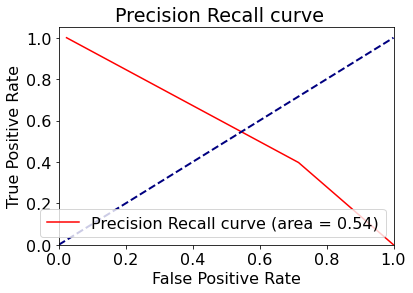

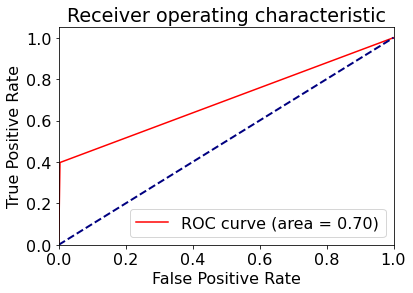

In [91]:
xgb_model_pred_test_2, xgb_model_prob_pred_test_2 = model_prediction(xgb_best_model_2, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     59000
         1.0       0.94      0.78      0.85      2000

    accuracy                           0.99     61000
   macro avg       0.97      0.89      0.92     61000
weighted avg       0.99      0.99      0.99     61000

[[58905    95]
 [  449  1551]]
Accuracy

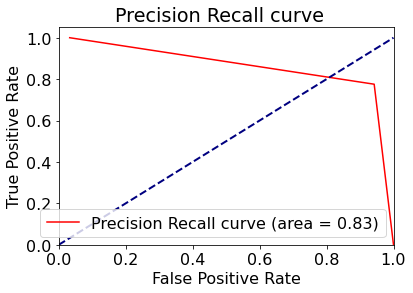

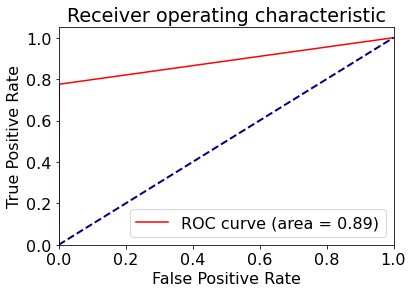

In [92]:
xgb_model_pred_train_2, xgb_model_prob_pred_train_2 = model_prediction(xgb_best_model_2, X_train_2)
model_evaluaiton(y_train_2, xgb_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [93]:
xgb_best_th_2 = find_cut_off(y_test, xgb_model_prob_pred_test_2[:,1])

100%|██████████| 7862/7862 [08:35<00:00, 15.25it/s]

Best threshold: 0.0153
Min cost: 12790.00


In [94]:
xgb_best_th_2

0.015262311

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.99      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14596  1029]
 [    5   370]]
Accuracy: 0.935375
roc_auc_score: 0.9604053333333333
precision_score: 0.2644746247319514
recall_score: 0.9866666666666667
f1_score: 0.4171364148816234
CM: FP 1029
CM: FN 5
APS Cost =  12790


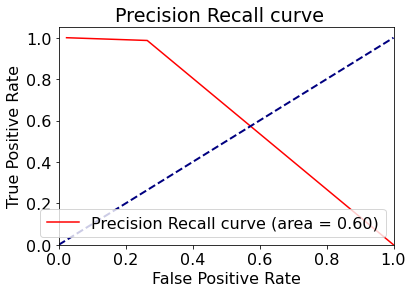

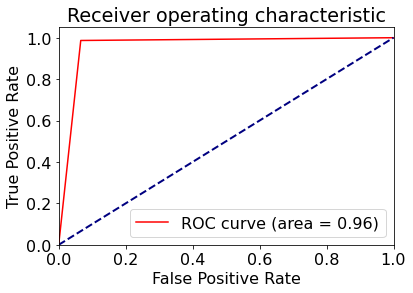

In [95]:
xgb_predict_test_th_2 = xgb_model_prob_pred_test_2[:,1] > xgb_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [96]:
(1.0-xgb_best_th_2)
xg_th_2 = round((1.0-xgb_best_th_2),3)
xg_th_2

0.9847376886755228

0.985

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.99      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14590  1035]
 [    5   370]]
Accuracy: 0.935
roc_auc_score: 0.9602133333333335
precision_score: 0.26334519572953735
recall_score: 0.9866666666666667
f1_score: 0.41573033707865165
CM: FP 1035
CM: FN 5
APS Cost =  12850


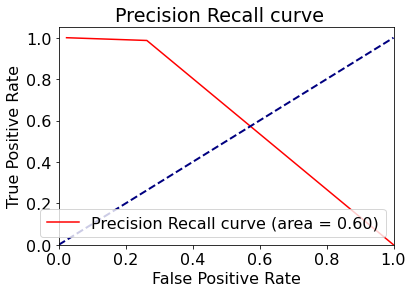

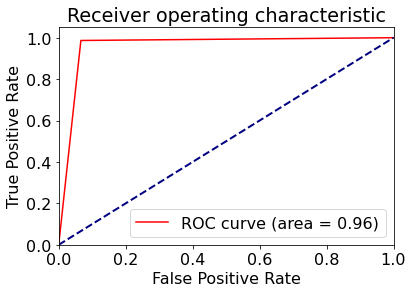

In [97]:
y_2 = xgb_model_prob_pred_test_2[:,0] < xg_th_2
model_evaluaiton(y_test, y_2, "")

-----

### df_train_5 (i.e. IR = 0.4)

In [98]:
X_train_5, y_train_5 = get_train_data(df_train_5)
xgb_best_model_5 = xgb_model(X_train_5, y_train_5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.8min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.72      0.37      0.49       375

    accuracy                           0.98     16000
   macro avg       0.85      0.68      0.74     16000
weighted avg       0.98      0.98      0.98     16000

[[15571    54]
 [  237   138]]
Accuracy

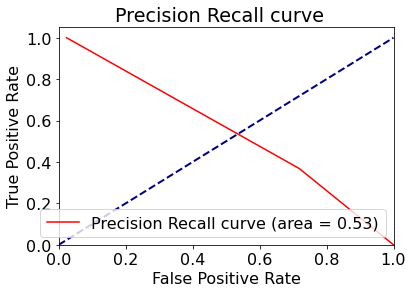

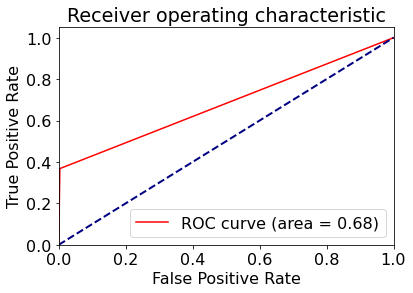

In [99]:
xgb_model_pred_test_5, xgb_model_prob_pred_test_5 = model_prediction(xgb_best_model_5, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       0.98      0.90      0.93      5000

    accuracy                           0.99     64000
   macro avg       0.98      0.95      0.96     64000
weighted avg       0.99      0.99      0.99     64000

[[58900   100]
 [  523  4477]]
Accuracy

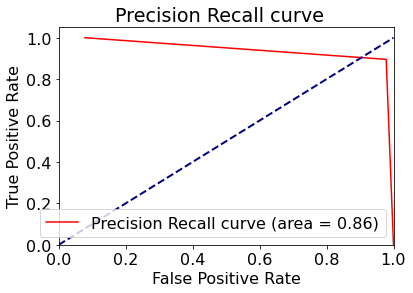

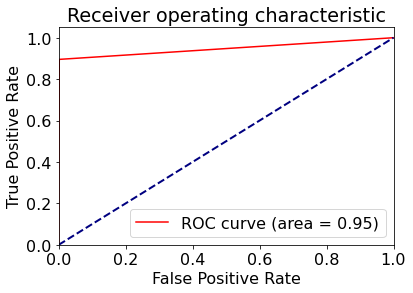

In [100]:
xgb_model_pred_train_5, xgb_model_prob_pred_train_5 = model_prediction(xgb_best_model_5, X_train_5)
model_evaluaiton(y_train_5, xgb_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [101]:
xgb_best_th_5 = find_cut_off(y_test, xgb_model_prob_pred_test_5[:,1])

100%|██████████| 7149/7149 [06:24<00:00, 18.60it/s]

Best threshold: 0.0307
Min cost: 12990.00


In [102]:
xgb_best_th_5

0.03071328

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.97      0.47       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14826   799]
 [   10   365]]
Accuracy: 0.9494375
roc_auc_score: 0.9610986666666667
precision_score: 0.313573883161512
recall_score: 0.9733333333333334
f1_score: 0.47433398310591296
CM: FP 799
CM: FN 10
APS Cost =  12990


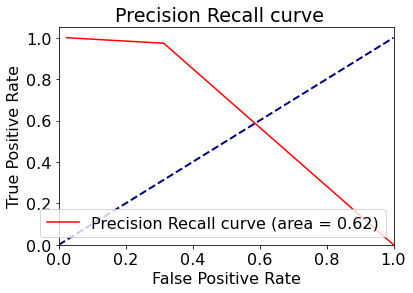

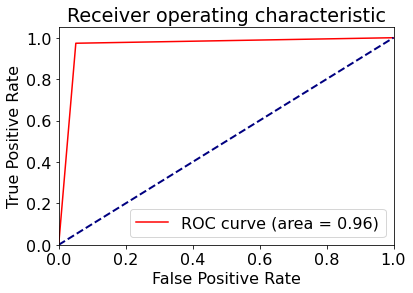

In [103]:
xgb_predict_test_th_5 = xgb_model_prob_pred_test_5[:,1] > xgb_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [104]:
(1.0-xgb_best_th_5)
xg_th_5 = round((1.0-xgb_best_th_5),3)
xg_th_5

0.9692867193371058

0.969

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.97      0.47       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14816   809]
 [   10   365]]
Accuracy: 0.9488125
roc_auc_score: 0.9607786666666667
precision_score: 0.31090289608177174
recall_score: 0.9733333333333334
f1_score: 0.47127178825048427
CM: FP 809
CM: FN 10
APS Cost =  13090


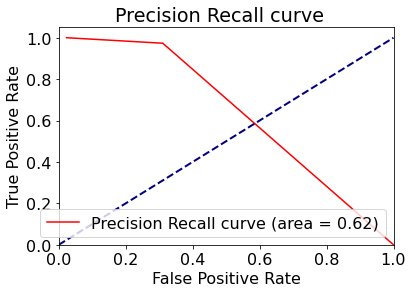

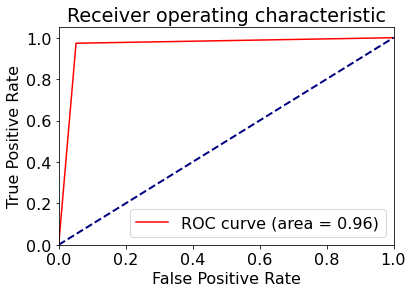

In [114]:
y_5 = xgb_model_prob_pred_test_5[:,0] < 0.97
model_evaluaiton(y_test, y_5, "")

----

### df_train_10 (i.e. IR = 0.6)

In [106]:
X_train_10, y_train_10 = get_train_data(df_train_10)
xgb_best_model_10 = xgb_model(X_train_10, y_train_10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.1min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.70      0.37      0.49       375

    accuracy                           0.98     16000
   macro avg       0.84      0.68      0.74     16000
weighted avg       0.98      0.98      0.98     16000

[[15566    59]
 [  236   139]]
Accuracy

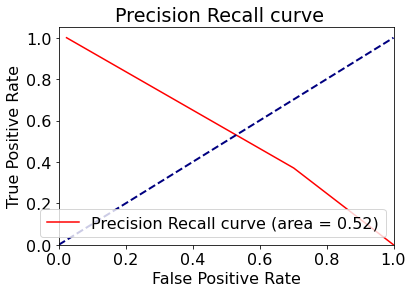

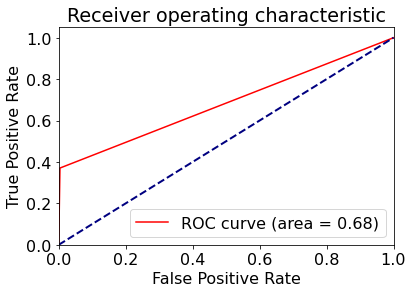

In [107]:
xgb_model_pred_test_10, xgb_model_prob_pred_test_10 = model_prediction(xgb_best_model_10, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       0.99      0.95      0.97     10000

    accuracy                           0.99     69000
   macro avg       0.99      0.97      0.98     69000
weighted avg       0.99      0.99      0.99     69000

[[58867   133]
 [  527  9473]]
Accuracy

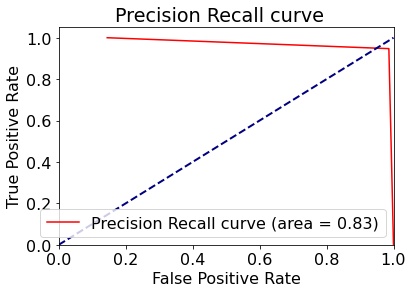

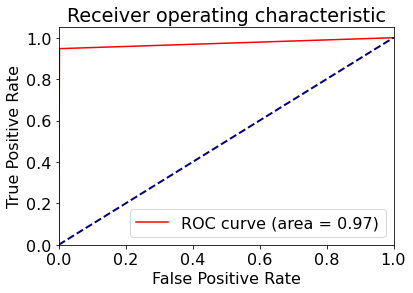

In [108]:
xgb_model_pred_train_10, xgb_model_prob_pred_train_10 = model_prediction(xgb_best_model_10, X_train_10)
model_evaluaiton(y_train_10, xgb_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [109]:
xgb_best_th_10 = find_cut_off(y_test, xgb_model_prob_pred_test_10[:,1])

100%|██████████| 7186/7186 [05:01<00:00, 23.81it/s]

Best threshold: 0.0237
Min cost: 13010.00


In [110]:
xgb_best_th_10

0.023687629

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.45       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14724   901]
 [    8   367]]
Accuracy: 0.9431875
roc_auc_score: 0.9605013333333333
precision_score: 0.2894321766561514
recall_score: 0.9786666666666667
f1_score: 0.44674376141205113
CM: FP 901
CM: FN 8
APS Cost =  13010


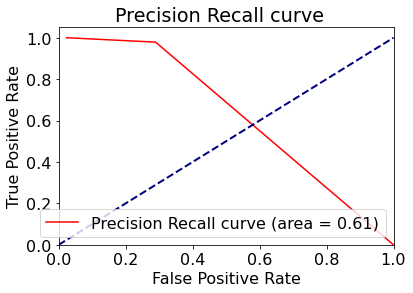

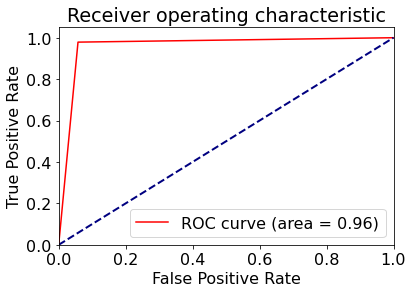

In [111]:
xgb_predict_test_th_10 = xgb_model_prob_pred_test_10[:,1] > xgb_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [112]:
(1.0-xgb_best_th_10)
xg_th_10 = round((1.0-xgb_best_th_10),3)
xg_th_10

0.9763123709708452

0.976

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.45       375

    accuracy                           0.94     16000
   macro avg       0.65      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14742   883]
 [    9   366]]
Accuracy: 0.94425
roc_auc_score: 0.9597439999999999
precision_score: 0.2930344275420336
recall_score: 0.976
f1_score: 0.45073891625615764
CM: FP 883
CM: FN 9
APS Cost =  13330


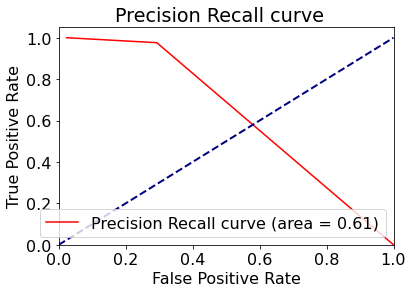

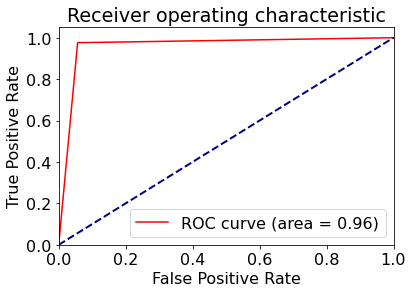

In [119]:
y_10 = xgb_model_prob_pred_test_10[:,0] < 0.975
model_evaluaiton(y_test, y_10, "")

-----